In this edited version of my kernel, I have included some new features and some others are under progress. Some have been influenced from [THIS KERNEL](https://www.kaggle.com/sudosudoohio/stratified-kfold-xgboost-eda-tutorial-0-281).

# What lies ahead of you?

*  **Data Exploration**
    * Analyzing Datatypes
    * Analyzing Missing Values
    * Visualizing missing values
    * Memory Usage Analysis
    
*  **Data Analysis** (visualizing each and every type of feature in the data set)
    * Splitting columns based on types
    * Binary Features
    * Categorical Features
    * Continuous/Ordinal Features
    * Correlation (**ps_calc** have an outrageous attitude!!!)
* **Feature Engineering** 
    * New Binary features
    * New Continuous/Ordinal features (*in progress*)
*  **Modeling**
    * Gradient Boosting
    * XGBoost

# Importing Libraries and Loading Data

In [1]:
import numpy as np # linear algebra
import seaborn as sns
import missingno as msno
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from subprocess import check_output
from sklearn import *
import xgboost as xgb
from multiprocessing import *

df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
#df_sample = pd.read_csv('../input/sample_submission.csv')
# Any results you write to the current directory are saved as output.

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
print(len(df_train.columns))
#new_cont_ord_cols = [c for c in df_train.columns if not c.startswith('ps_calc_')]
new_cont_ord_cols = [c for c in df_train.columns if not c.endswith('bin')]
no_bin_cat_cols = [c for c in new_cont_ord_cols if not c.endswith('cat')][2:]

59


In [3]:
#''' 
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
col = [c for c in train.columns if c not in ['id','target']]
print(len(col))
col = [c for c in col if not c.startswith('ps_calc_')]
print(len(col))

train = train.replace(-1, np.NaN)
d_median = train.median(axis=0)
d_mean = train.mean(axis=0)
train = train.fillna(-1)
one_hot = {c: list(train[c].unique()) for c in train.columns if c not in ['id','target']}

#'''

57
37


In [4]:
'''
def transform_df(df):
    df = pd.DataFrame(df)
    dcol = [c for c in df.columns if c not in ['id','target']]
    df['ps_car_13_x_ps_reg_03'] = df['ps_car_13'] * df['ps_reg_03']
    df['negative_one_vals'] = np.sum((df[dcol]==-1).values, axis=1)
    for c in dcol:
        if '_bin' not in c: #standard arithmetic
            df[c+str('_median_range')] = (df[c].values > d_median[c]).astype(np.int)
            df[c+str('_mean_range')] = (df[c].values > d_mean[c]).astype(np.int)
            #df[c+str('_sq')] = np.power(df[c].values,2).astype(np.float32)
            #df[c+str('_sqr')] = np.square(df[c].values).astype(np.float32)
            #df[c+str('_log')] = np.log(np.abs(df[c].values) + 1)
            #df[c+str('_exp')] = np.exp(df[c].values) - 1
    for c in one_hot:
        if len(one_hot[c])>2 and len(one_hot[c]) < 7:
            for val in one_hot[c]:
                df[c+'_oh_' + str(val)] = (df[c].values == val).astype(np.int)
    return df

def multi_transform(df):
    print('Init Shape: ', df.shape)
    p = Pool(cpu_count())
    df = p.map(transform_df, np.array_split(df, cpu_count()))
    df = pd.concat(df, axis=0, ignore_index=True).reset_index(drop=True)
    p.close(); p.join()
    print('After Shape: ', df.shape)
    return df

def gini(y, pred):
    fpr, tpr, thr = metrics.roc_curve(y, pred, pos_label=1)
    g = 2 * metrics.auc(fpr, tpr) -1
    return g

def gini_xgb(pred, y):
    y = y.get_label()
    return 'gini', gini(y, pred)

params = {'eta': 0.02, 'max_depth': 4, 'subsample': 0.9, 'colsample_bytree': 0.9, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'seed': 99, 'silent': True}
x1, x2, y1, y2 = model_selection.train_test_split(train, train['target'], test_size=0.25, random_state=99)

x1 = multi_transform(x1)
x2 = multi_transform(x2)
test = multi_transform(test)

col = [c for c in x1.columns if c not in ['id','target']]
col = [c for c in col if not c.startswith('ps_calc_')]
print(x1.values.shape, x2.values.shape)

#remove duplicates just in case
tdups = multi_transform(train)
dups = tdups[tdups.duplicated(subset=col, keep=False)]

x1 = x1[~(x1['id'].isin(dups['id'].values))]
x2 = x2[~(x2['id'].isin(dups['id'].values))]
print(x1.values.shape, x2.values.shape)

y1 = x1['target']
y2 = x2['target']
x1 = x1[col]
x2 = x2[col]

watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
model = xgb.train(params, xgb.DMatrix(x1, y1), 5000,  watchlist, feval=gini_xgb, maximize=True, verbose_eval=50, early_stopping_rounds=200)
test['target'] = model.predict(xgb.DMatrix(test[col]), ntree_limit=model.best_ntree_limit+45)
test['target'] = (np.exp(test['target'].values) - 1.0).clip(0,1)

sub = pd.DataFrame()
sub['id'] = test['id']
sub['target'] = test['target']
sub.to_csv('xgb1.csv', index=False)

#test[['id','target']].to_csv('xgb_submission.csv', index=False, float_format='%.5f')
'''

"\ndef transform_df(df):\n    df = pd.DataFrame(df)\n    dcol = [c for c in df.columns if c not in ['id','target']]\n    df['ps_car_13_x_ps_reg_03'] = df['ps_car_13'] * df['ps_reg_03']\n    df['negative_one_vals'] = np.sum((df[dcol]==-1).values, axis=1)\n    for c in dcol:\n        if '_bin' not in c: #standard arithmetic\n            df[c+str('_median_range')] = (df[c].values > d_median[c]).astype(np.int)\n            df[c+str('_mean_range')] = (df[c].values > d_mean[c]).astype(np.int)\n            #df[c+str('_sq')] = np.power(df[c].values,2).astype(np.float32)\n            #df[c+str('_sqr')] = np.square(df[c].values).astype(np.float32)\n            #df[c+str('_log')] = np.log(np.abs(df[c].values) + 1)\n            #df[c+str('_exp')] = np.exp(df[c].values) - 1\n    for c in one_hot:\n        if len(one_hot[c])>2 and len(one_hot[c]) < 7:\n            for val in one_hot[c]:\n                df[c+'_oh_' + str(val)] = (df[c].values == val).astype(np.int)\n    return df\n\ndef multi_transf

# Data Exploration

First things first, let us explore what we have!

In [5]:
df_train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


Saving the **target** variable separately and dropping it from the training set.

In [6]:
target = df_train['target']
df_train = df_train.drop('target', 1)

## Analyzing Datatypes

We only have two datatypes in our dataset: **int** and **float**.

In [7]:
print(df_train.dtypes.unique())
print(df_train.dtypes.nunique())

print(df_test.dtypes.unique())
print(df_test.dtypes.nunique())

[dtype('int64') dtype('float64')]
2
[dtype('int64') dtype('float64')]
2


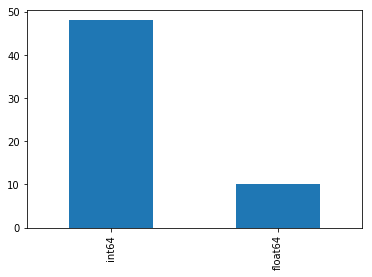

In [8]:
pp = pd.value_counts(df_train.dtypes)
pp.plot.bar()
plt.show()

## Analyzing Missing Values

In [9]:
print (df_train.isnull().values.any())
print (df_test.isnull().values.any())

False
False


However, as mentioned by someone in the comments, "This isn't true!" The missing values have been replaced by -1.

We will replace them using np.nan and see how it is distributed.



In [10]:
#df_train.replace(-1, np.nan)
#df_test.replace(-1, np.nan)
df_train[(df_train == -1)] = np.nan
df_test[(df_test == -1)] = np.nan

print('done') 

done


Checking for missing values again

In [11]:
print (df_train.isnull().values.any())
print (df_test.isnull().values.any())   

True
True


Printing list of columns with missing values in both the train and test dataframe:

In [12]:
cols_missing_val_train = df_train.columns[df_train.isnull().any()].tolist()
print(cols_missing_val_train)
print('\n')

cols_missing_val_test = df_test.columns[df_test.isnull().any()].tolist()
print(cols_missing_val_test)

['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_07_cat', 'ps_car_09_cat', 'ps_car_11', 'ps_car_12', 'ps_car_14']


['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_07_cat', 'ps_car_09_cat', 'ps_car_11', 'ps_car_14']


We see that the train dataframe has an extra column with missing values (**ps_car_12**).

## Visualizing missing values

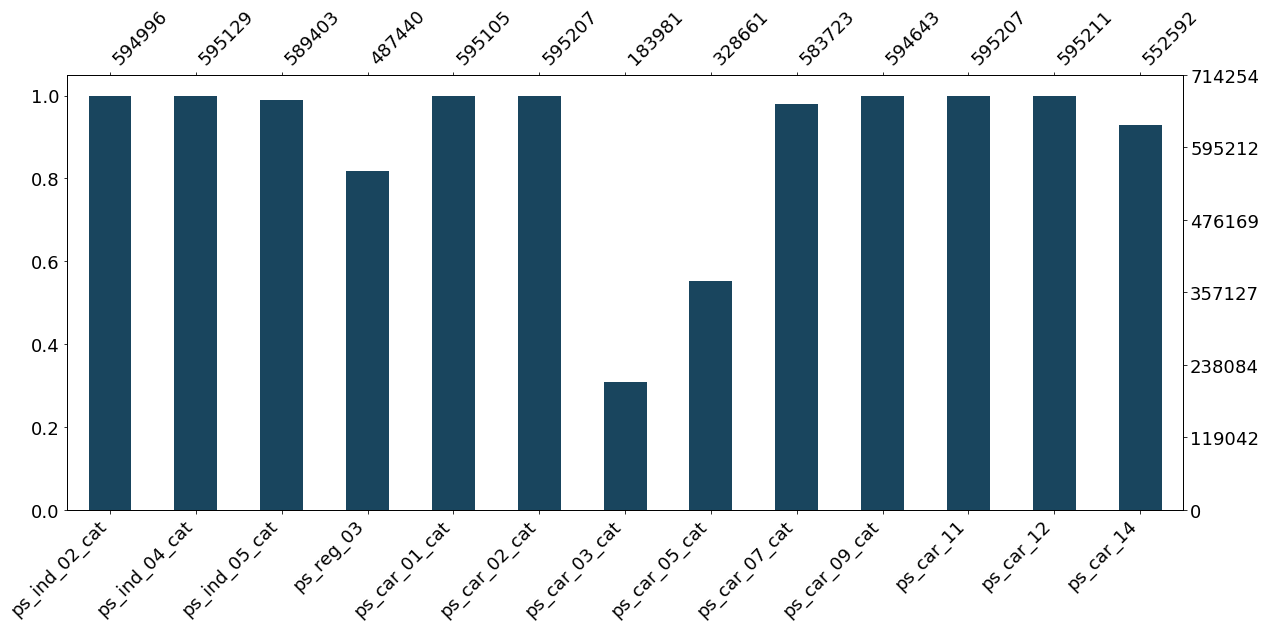

In [13]:
#--- Train dataframe ---
msno.bar(df_train[cols_missing_val_train],figsize=(20,8),color="#19455e",fontsize=18,labels=True,)

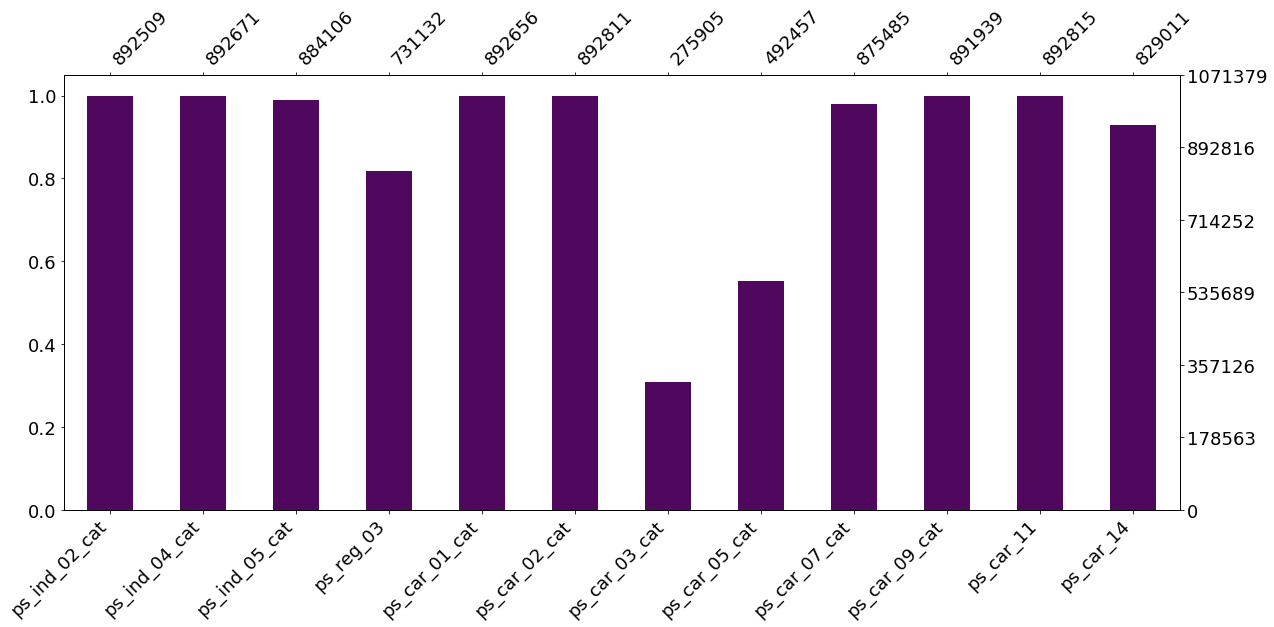

In [14]:
#--- Test dataframe ---
msno.bar(df_test[cols_missing_val_test],figsize=(20,8),color="#50085e",fontsize=18,labels=True,)

We can see that the missing values a proportional in both the test and train dataframes.

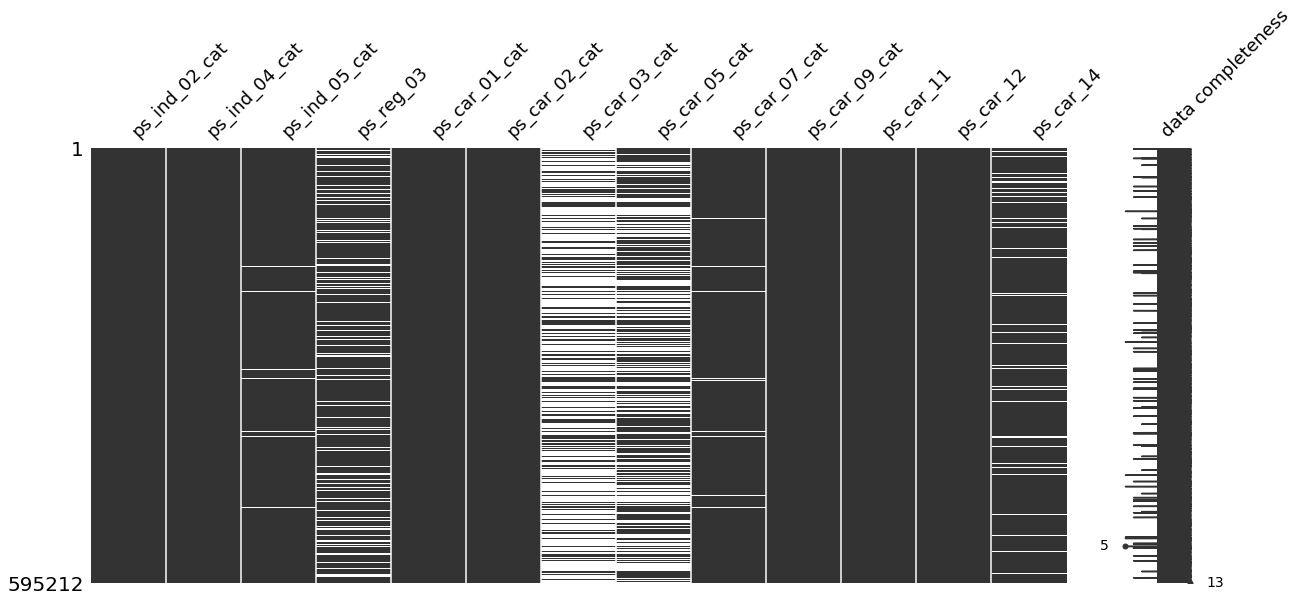

In [15]:
#--- Train dataframe ---
msno.matrix(df_train[cols_missing_val_train],width_ratios=(10,1),\
            figsize=(20,8),color=(0.2,0.2,0.2),fontsize=18,sparkline=True,labels=True)

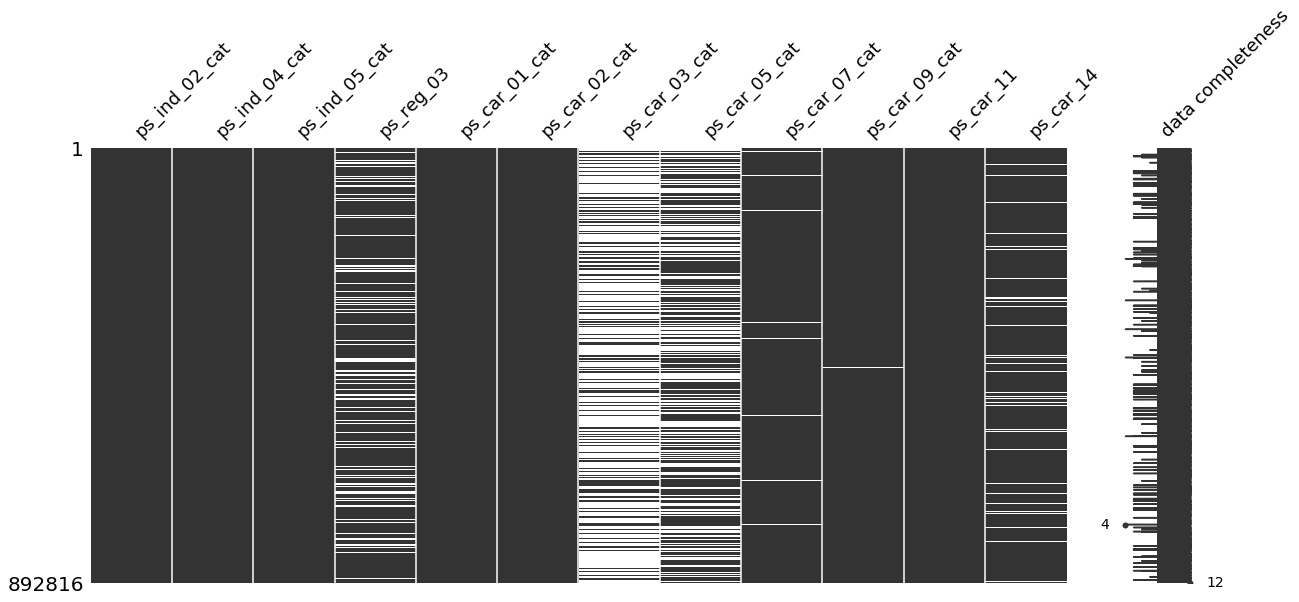

In [16]:
#--- Test dataframe ---
msno.matrix(df_test[cols_missing_val_test],width_ratios=(10,1),\
            figsize=(20,8),color=(0.2,0.2,0.2),fontsize=18,sparkline=True,labels=True)

We see a similar resemblance of proportional missing values in the train and test dataframes!

## Memory Usage

In [17]:
#--- memory consumed by train dataframe ---
mem = df_train.memory_usage(index=True).sum()
print("Memory consumed by training set  :   {} MB" .format(mem/ 1024**2))
print('\n')
#--- memory consumed by test dataframe ---
mem = df_test.memory_usage(index=True).sum()
print("Memory consumed by test set      :   {} MB" .format(mem/ 1024**2))

Memory consumed by training set  :   263.38429260253906 MB


Memory consumed by test set      :   395.0755157470703 MB


By altering the datatypes we can reduce memory usage:

In [18]:
def change_datatype(df):
    float_cols = list(df.select_dtypes(include=['int']).columns)
    for col in float_cols:
        if ((np.max(df[col]) <= 127) and(np.min(df[col] >= -128))):
            df[col] = df[col].astype(np.int8)
        elif ((np.max(df[col]) <= 32767) and(np.min(df[col] >= -32768))):
            df[col] = df[col].astype(np.int16)
        elif ((np.max(df[col]) <= 2147483647) and(np.min(df[col] >= -2147483648))):
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)

change_datatype(df_train)
change_datatype(df_test) 

In [19]:
#--- Converting columns from 'float64' to 'float32' ---
def change_datatype_float(df):
    float_cols = list(df.select_dtypes(include=['float']).columns)
    for col in float_cols:
        df[col] = df[col].astype(np.float32)
        
change_datatype_float(df_train)
change_datatype_float(df_test)

Let us check the memory consumed again:

In [20]:
#--- memory consumed by train dataframe ---
mem = df_train.memory_usage(index=True).sum()
print("Memory consumed by training set  :   {} MB" .format(mem/ 1024**2))
print('\n') 
#--- memory consumed by test dataframe ---
mem = df_test.memory_usage(index=True).sum()
print("Memory consumed by test set      :   {} MB" .format(mem/ 1024**2))

Memory consumed by training set  :   68.68432235717773 MB


Memory consumed by test set      :   103.02621459960938 MB


That is memory consumption reduced by **greater than 50%** !!!

In [21]:
print(len(df_test.columns))
print(len(df_train.columns))
#print(len(target.columns))

58
58


# Data Analysis
## Splitting columns based on types
According to the data given to us:
* features that belong to similar groupings are tagged as such in the feature names (e.g., **ind**, **reg**, **car**, **calc**). 
* feature names include the postfix **bin** to indicate binary features and **cat** to indicate categorical features.
* feature names without **boon** or **cat** are grouped as** continuous/ordinal** features.

In [22]:
#-- List of all columns --
train_cols = df_train.columns.tolist()

#--- binary and categorical features list ---
bin_cols = []
cat_cols = []

#--- continous/ordinal features list ---
cont_ord_cols = []

#--- different feature groupings ---
ind_cols = []
reg_cols = []
car_cols = []
calc_cols = []

for col in train_cols:
    if (('ps' in str(col)) & ('bin' not in str(col)) & ('cat' not in str(col))):
        cont_ord_cols.append(col)
    
for col in train_cols:
    if ('bin' in str(col)):
        bin_cols.append(col)
    if ('cat' in str(col)):
        cat_cols.append(col)
        
    if ('ind' in str(col)):
        ind_cols.append(col)
    if ('reg' in str(col)):
        reg_cols.append(col)
    if ('car' in str(col)):
        car_cols.append(col)
    if ('calc' in str(col)):
        calc_cols.append(col)
        

Exploring each of the above extracted grouped features individually:

## Binary features:

Binary features whose single attribute is less than 10% will be collected in a separate list

ps_ind_06_bin
[0 1]


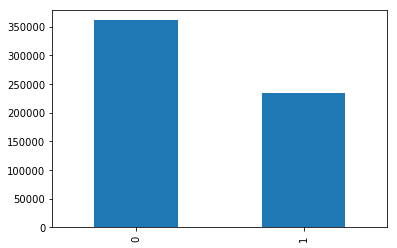

ps_ind_07_bin
[1 0]


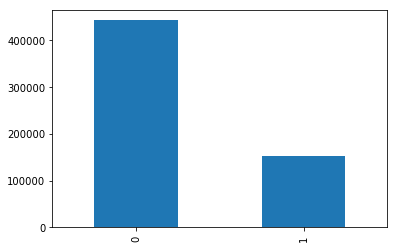

ps_ind_08_bin
[0 1]


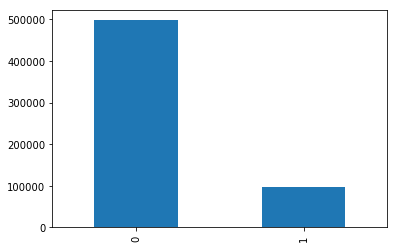

ps_ind_09_bin
[0 1]


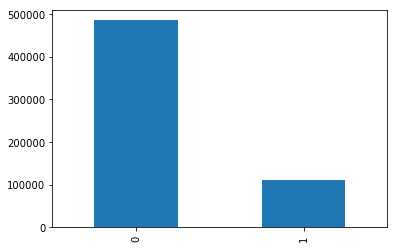

ps_ind_10_bin
[0 1]


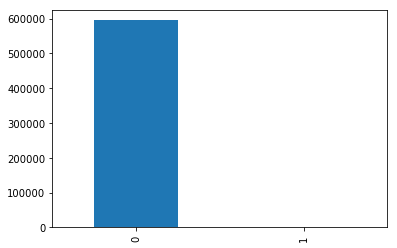

ps_ind_11_bin
[0 1]


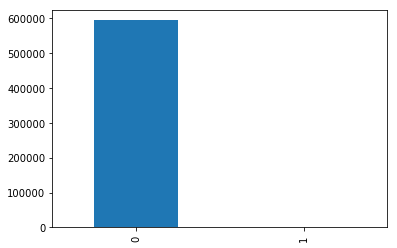

ps_ind_12_bin
[0 1]


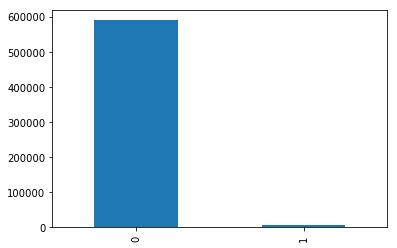

ps_ind_13_bin
[0 1]


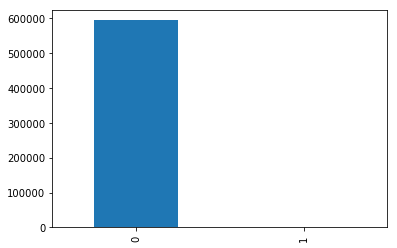

ps_ind_16_bin
[0 1]


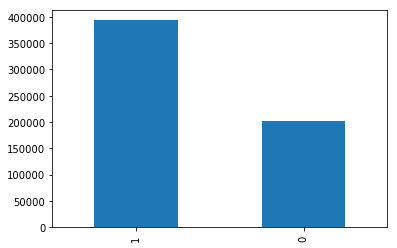

ps_ind_17_bin
[1 0]


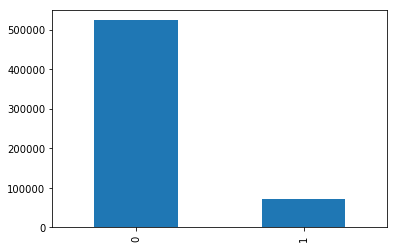

ps_ind_18_bin
[0 1]


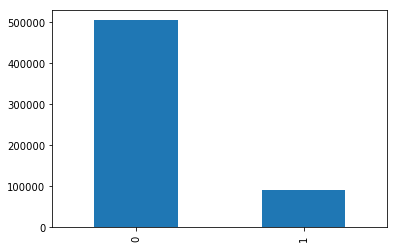

ps_calc_15_bin
[0 1]


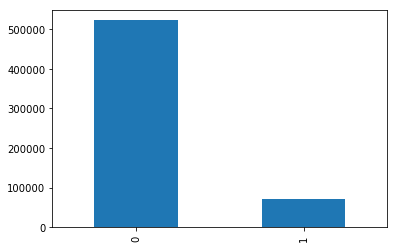

ps_calc_16_bin
[1 0]


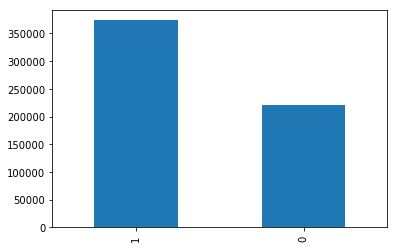

ps_calc_17_bin
[1 0]


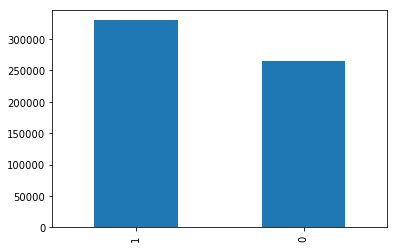

ps_calc_18_bin
[0 1]


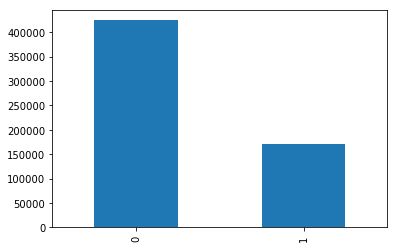

ps_calc_19_bin
[0 1]


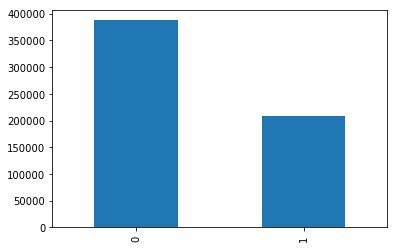

ps_calc_20_bin
[1 0]


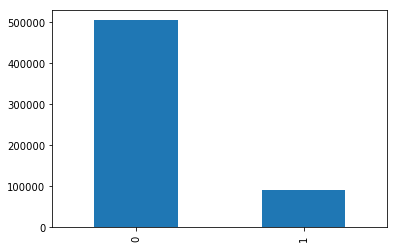

In [23]:
cols_to_delete = []
th = 0.1
for col in range(0, len(bin_cols)):
    print (bin_cols[col])
    print (df_train[bin_cols[col]].unique())
    pp = pd.value_counts(df_train[bin_cols[col]])
    
    for i in range(0, len(pp)):
        if((pp[i]/float(len(df_train))) <= th):
            cols_to_delete.append(bin_cols[col])
            
    pp.plot.bar()
    plt.show()

In [24]:
print(cols_to_delete)

['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin']


The above mentioned columns have higly skewed values hence can be dropped from both the training and test set.

In [25]:
 
for col in cols_to_delete:
    df_train.drop([col], axis=1, inplace=True)
    df_test.drop([col], axis=1, inplace=True)
    

## Categorical Features

Exploring the categorical variables:

ps_ind_02_cat
[  2.   1.   4.   3.  nan]


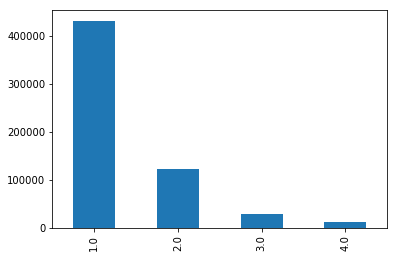

ps_ind_04_cat
[  1.   0.  nan]


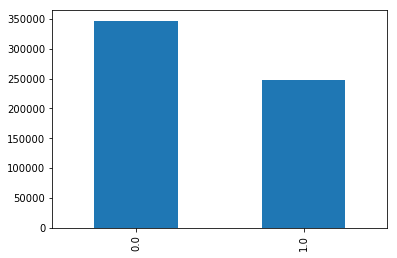

ps_ind_05_cat
[  0.   1.   4.   3.   6.   5.  nan   2.]


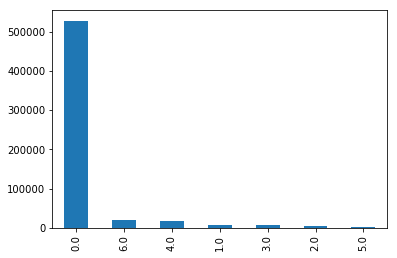

ps_car_01_cat
[ 10.  11.   7.   6.   9.   5.   4.   8.   3.   0.   2.   1.  nan]


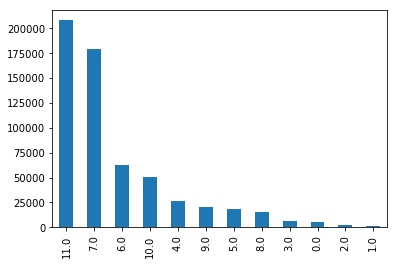

ps_car_02_cat
[  1.   0.  nan]


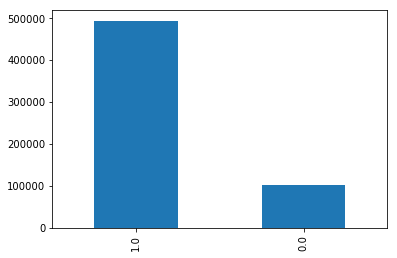

ps_car_03_cat
[ nan   0.   1.]


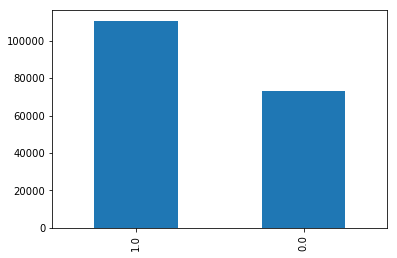

ps_car_04_cat
[0 1 8 9 2 6 3 7 4 5]


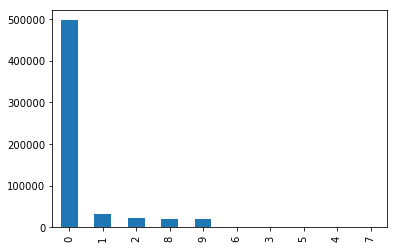

ps_car_05_cat
[  1.  nan   0.]


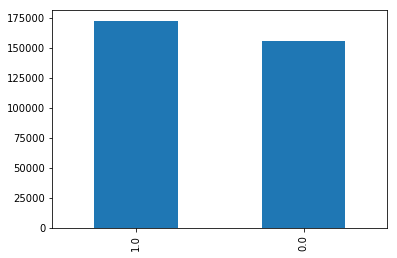

ps_car_06_cat
[ 4 11 14 13  6 15  3  0  1 10 12  9 17  7  8  5  2 16]


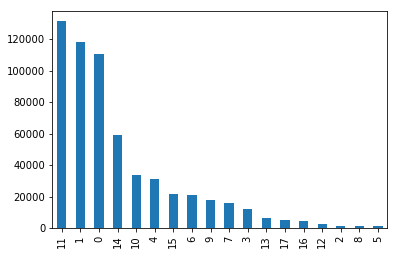

ps_car_07_cat
[  1.  nan   0.]


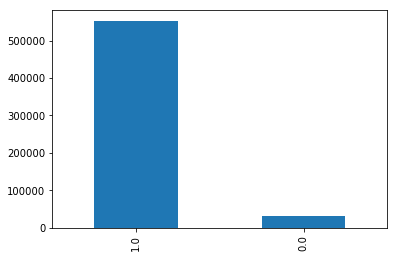

ps_car_08_cat
[0 1]


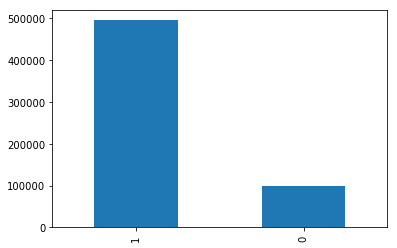

ps_car_09_cat
[  0.   2.   3.   1.  nan   4.]


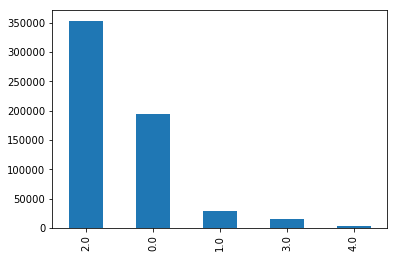

ps_car_10_cat
[1 0 2]


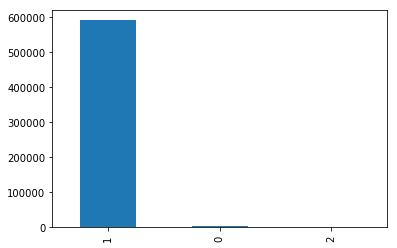

ps_car_11_cat
[ 12  19  60 104  82  99  30  68  20  36 101 103  41  59  43  64  29  95
  24   5  28  87  66  10  26  54  32  38  83  89  49  93   1  22  85  78
  31  34   7   8   3  46  27  25  61  16  69  40  76  39  88  42  75  91
  23   2  71  90  80  44  92  72  96  86  62  33  67  73  77  18  21  74
  37  48  70  13  15 102  53  65 100  51  79  52  63  94   6  57  35  98
  56  97  55  84  50   4  58   9  17  11  45  14  81  47]


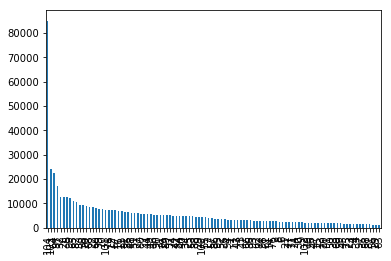

In [26]:
for col in range(0, len(cat_cols)):
    print (cat_cols[col])
    print (df_train[cat_cols[col]].unique())
    pp = pd.value_counts(df_train[cat_cols[col]])      
    pp.plot.bar()
    plt.show()

From the graphs, only **ps_car_10_cat** is highly skewed hence can be removed from training and test set.

In [27]:
''' cat_cols_to_delete = [ 'ps_car_10_cat']

for col in cat_cols_to_delete:
    df_train.drop([col], axis=1, inplace=True)
    df_test.drop([col], axis=1, inplace=True) ''' 

" cat_cols_to_delete = [ 'ps_car_10_cat']\n\nfor col in cat_cols_to_delete:\n    df_train.drop([col], axis=1, inplace=True)\n    df_test.drop([col], axis=1, inplace=True) "

## Continuous/Ordinal Features

Features having different prefixes such as **ind**, **reg**, **car** and **calc**; excluding binary and categorical features.

In [28]:
ind_cols_no_bin_cat = []
reg_cols_no_bin_cat = []
car_cols_no_bin_cat = []
calc_cols_no_bin_cat = []

for col in train_cols:
    if (('ind' in str(col)) and ('bin' not in str(col)) and ('cat' not in str(col))):
        ind_cols_no_bin_cat.append(col)
    if (('reg' in str(col)) and ('bin' not in str(col)) and ('cat' not in str(col))):
        reg_cols_no_bin_cat.append(col)
    if (('car' in str(col)) and ('bin' not in str(col)) and ('cat' not in str(col))):
        car_cols_no_bin_cat.append(col)
    if (('calc' in str(col)) and ('bin' not in str(col)) and ('cat' not in str(col))):
        calc_cols_no_bin_cat.append(col)

### Visualizing **ind** features

(Uncomment the following snippets of code to visualzie the various grouped features. They take a long time to load hence I have commented them out)

In [29]:
'''
what_col = ind_cols_no_bin_cat
for col in range(0, len(what_col)):
    print (what_col[col])
    print (df_train[what_col[col]].unique())
    pp = pd.value_counts(df_train[what_col[col]])      
    pp.plot.bar()
    plt.show()
'''   

'\nwhat_col = ind_cols_no_bin_cat\nfor col in range(0, len(what_col)):\n    print (what_col[col])\n    print (df_train[what_col[col]].unique())\n    pp = pd.value_counts(df_train[what_col[col]])      \n    pp.plot.bar()\n    plt.show()\n'

Column **ps_ind_14** is heavily skewed hence can be removed.

### Visualizing **reg** features

In [30]:
'''
what_col = reg_cols_no_bin_cat
for col in range(0, len(what_col)):
    print (what_col[col])
    print (df_train[what_col[col]].unique())
    pp = pd.value_counts(df_train[what_col[col]])      
    pp.plot.bar()
    plt.show()
 '''  

'\nwhat_col = reg_cols_no_bin_cat\nfor col in range(0, len(what_col)):\n    print (what_col[col])\n    print (df_train[what_col[col]].unique())\n    pp = pd.value_counts(df_train[what_col[col]])      \n    pp.plot.bar()\n    plt.show()\n '

Column **ps_reg_03** does not seem to show anything at all, hence can be removed.

### Visualizing **car** features

In [31]:
''' 
what_col = car_cols_no_bin_cat
for col in range(0, len(what_col)):
    print (what_col[col])
    print (df_train[what_col[col]].unique())
    pp = pd.value_counts(df_train[what_col[col]])      
    pp.plot.bar()
    plt.show()
'''

' \nwhat_col = car_cols_no_bin_cat\nfor col in range(0, len(what_col)):\n    print (what_col[col])\n    print (df_train[what_col[col]].unique())\n    pp = pd.value_counts(df_train[what_col[col]])      \n    pp.plot.bar()\n    plt.show()\n'

### Visualizing **calc** features

In [32]:
''' 
what_col = calc_cols_no_bin_cat
for col in range(0, len(what_col)):
    print (what_col[col])
    print (df_train[what_col[col]].unique())
    pp = pd.value_counts(df_train[what_col[col]])      
    pp.plot.bar()
    plt.show()
'''

' \nwhat_col = calc_cols_no_bin_cat\nfor col in range(0, len(what_col)):\n    print (what_col[col])\n    print (df_train[what_col[col]].unique())\n    pp = pd.value_counts(df_train[what_col[col]])      \n    pp.plot.bar()\n    plt.show()\n'

Colukmns belonging to type ***calc***: 
* **ps_calc_01**,
* **ps_calc_02**,
* **ps_calc_03** 

have a uniform distribution, which do not offer anything significant. Hence these can also be removed.

In [33]:
''' other_cols_to_delete = ['ps_ind_14', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_reg_03']

for col in other_cols_to_delete:
    df_train.drop([col], axis=1, inplace=True)
    df_test.drop([col], axis=1, inplace=True)''' 

" other_cols_to_delete = ['ps_ind_14', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_reg_03']\n\nfor col in other_cols_to_delete:\n    df_train.drop([col], axis=1, inplace=True)\n    df_test.drop([col], axis=1, inplace=True)"

# Feature Engineering

### NOTE: ALWAYS REMEMBER TO INCLUDE SAME SET OF FEATURES FOR THE TEST DATA ALSO!!
## New Binary Features

Here I have included logical AND, OR and XOR operation between every binary feature.

In [34]:
train_cols = df_train.columns
bin_cols = df_train.columns[df_train.columns.str.endswith('bin')]
''' 
for i in ["X1","X2"]:
    for j in ["X2","X3"]:
        if i != j:
            col_name = i + j
            k[col_name + '_OR'] = k[i]|k[j] 
            k[col_name + '_AND'] = k[i]&k[j] 
            k[col_name + '_XOR'] = k[i]^k[j] 
'''            
def second_order(df, c_names):
    names_col=[]
    pp=0
    for i in c_names[:c_names.size-1]:
        for j in c_names[pp:c_names.size]:
            if i != j:
                col_name = i + str('_') + j
                df[col_name + '_OR'] = df[i]|df[j] 
                df[col_name + '_AND'] = df[i]&df[j] 
                df[col_name + '_XOR'] = df[i]^df[j]
            
                #col_name = ii + str('_and_') + jj
                #names_col.append(col_name)
                #df[col_name] = df[ii]&df[jj]
        pp+=1
    return df, names_col   

df_train, train_new_cols = second_order(df_train, bin_cols)
df_test, test_new_cols = second_order(df_test, bin_cols)

print(len(df_train.columns))
print(len(df_test.columns))

288
288


## New Continuous/Ordinal Features (*in progress*)

In [35]:
''' 
print(len(df_train.columns))
#new_cont_ord_cols = [c for c in df_train.columns if not c.startswith('ps_calc_')]
#new_cont_ord_cols = [c for c in df_train.columns if not c.endswith('bin') ]
for col in no_bin_cat_cols:
    #df_train[col + str('_greater_median')] = (df_train[col].values > df_train[col].median()).astype(np.int)
    #df_train[col + str('_greater_mean')] = (df_train[col].values > df_train[col].mean()).astype(np.int)
    df_train[col + str('_sq')] = np.power(df_train[col].values,2).astype(np.float32)
    df_train[col + str('_sqr')] = np.square(df_train[col].values).astype(np.float32)
    df_train[col + str('_log')] = np.log(np.abs(df_train[col].values) + 1)
    #df_train[col + str('_exp')] = np.exp(df_train[col].values) - 1
    
#new_cont_ord_test_cols = [c for c in df_test.columns if not c.startswith('ps_calc_')]
for col in no_bin_cat_cols:
    #df_test[col + str('_greater_median')] = (df_test[col].values > df_test[col].median()).astype(np.int)
    #df_test[col + str('_greater_mean')] = (df_test[col].values > df_test[col].mean()).astype(np.int)
    df_test[col + str('_sq')] = np.power(df_test[col].values,2).astype(np.float32)
    df_test[col + str('_sqr')] = np.square(df_test[col].values).astype(np.float32)
    df_test[col + str('_log')] = np.log(np.abs(df_test[col].values) + 1)
    #df_test[col + str('_exp')] = np.exp(df_test[col].values) - 1    
'''    

" \nprint(len(df_train.columns))\n#new_cont_ord_cols = [c for c in df_train.columns if not c.startswith('ps_calc_')]\n#new_cont_ord_cols = [c for c in df_train.columns if not c.endswith('bin') ]\nfor col in no_bin_cat_cols:\n    #df_train[col + str('_greater_median')] = (df_train[col].values > df_train[col].median()).astype(np.int)\n    #df_train[col + str('_greater_mean')] = (df_train[col].values > df_train[col].mean()).astype(np.int)\n    df_train[col + str('_sq')] = np.power(df_train[col].values,2).astype(np.float32)\n    df_train[col + str('_sqr')] = np.square(df_train[col].values).astype(np.float32)\n    df_train[col + str('_log')] = np.log(np.abs(df_train[col].values) + 1)\n    #df_train[col + str('_exp')] = np.exp(df_train[col].values) - 1\n    \n#new_cont_ord_test_cols = [c for c in df_test.columns if not c.startswith('ps_calc_')]\nfor col in no_bin_cat_cols:\n    #df_test[col + str('_greater_median')] = (df_test[col].values > df_test[col].median()).astype(np.int)\n    #df_test

## New Second Order Continuous/Ordinal Features (*based on Gradient Boosting feature importance*)

In [36]:
new_col =['ps_car_12', 'ps_car_14', 'ps_car_15', 'ps_car_13', 'ps_reg_03', 'ps_ind_03', 'ps_ind_15', 'ps_reg_02', 'ps_reg_01', 'ps_calc_02', 'ps_calc_11', 'ps_calc_10']


def new_second_order(df, c_names):
    names_col=[]
    pp=0
    for i in c_names[:len(c_names)-1]:
        for j in c_names[pp:len(c_names)]:
            if i != j:
                col_name = i + str('_*_') + j
                df[col_name] = df[i] * df[j] 
                
            
                #col_name = ii + str('_and_') + jj
                #names_col.append(col_name)
                #df[col_name] = df[ii]&df[jj]
        pp+=1
    return df, names_col   

df_train, train_new_cols = new_second_order(df_train, new_col)
df_test, test_new_cols = new_second_order(df_test, new_col)

In [37]:
print(len(df_train.columns))
print(len(df_test.columns))

354
354


## Correlation

In [38]:
''' 
sns.set(style="white")
corr = df_train.corr()
f, ax = plt.subplots(figsize=(18, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()
'''

' \nsns.set(style="white")\ncorr = df_train.corr()\nf, ax = plt.subplots(figsize=(18, 15))\ncmap = sns.diverging_palette(220, 10, as_cmap=True)\nsns.heatmap(corr, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})\nplt.show()\n'

Outrageous! Not even a single **calc** feature seems to have any interest in indulging themselves with anything!! It is better to remove them all!!

In [39]:
'''
removed_calc_cols = []
for col in df_train.columns:
    if ('calc' in str(col)):
        removed_calc_cols.append(col)
    
#unwanted = train.columns[train.columns.str.startswith('ps_calc_')]

df_train = df_train.drop(removed_calc_cols, axis=1)  
df_test = df_test.drop(removed_calc_cols, axis=1)  
''' 

"\nremoved_calc_cols = []\nfor col in df_train.columns:\n    if ('calc' in str(col)):\n        removed_calc_cols.append(col)\n    \n#unwanted = train.columns[train.columns.str.startswith('ps_calc_')]\n\ndf_train = df_train.drop(removed_calc_cols, axis=1)  \ndf_test = df_test.drop(removed_calc_cols, axis=1)  \n"

In [40]:
df_train.replace(np.nan, -1, inplace=True)
df_test.replace(np.nan, -1, inplace=True)
print('Done')

Done


# Modeling
## Gradient Boosting

In [41]:
X_train = df_train.drop(['id'],axis = 1)
X_id_train = df_train['id'].values
Y_train = target.values

X_test = df_test.drop(['id'], axis=1)
X_id_test = df_test['id'].values

In [42]:
#''' 
from sklearn.ensemble import GradientBoostingRegressor

GBR = GradientBoostingRegressor(n_estimators=80, learning_rate=0.01, max_depth=5, random_state=0, loss='ls')
GBR.fit(X_train, Y_train)

print (GBR)
#'''

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=80, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False)


In [43]:
#--- List of important features for Gradient Boosting Regressor ---
#''' 
features_list = X_train.columns.values
feature_importance = GBR.feature_importances_
sorted_idx = np.argsort(feature_importance)

print(sorted_idx)
#''' 

[176 175 177 178 180 183 186 187 188 190 191 192 193 194 174 195 198 199
 200 201 202 204 206 207 208 209 211 212 213 197 173 172 171 133 134 135
 136 137 139 140 141 142 145 146 148 150 151 153 154 156 158 160 161 162
 163 164 165 166 167 168 169 170 214 215 217 218 254 255 256 257 258 259
 260 262 263 264 266 268 269 270 271 272 273 274 276 277 278 279 280 282
 283 284 285 286 328 253 132 252 249 219 220 221 222 223 224 225 226 227
 228 229 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246
 247 248 251 131 159 129  57  58  60 340  66  68  69  70  71  72  73  74
  76  77  79  80  81  83  84  86  87  55  88  54  52   2   5   6   7   8
  11  13  14  18  20  21  24  26  34  37  44  47  48  49  50  51  53  90
  56 112 113 101 120 102 103 104 121 105 106 107 108 118 117 116 119 109
 122 115  97  96 123  95 114 127 124 337  93  92 110 126  75  63 189 281
 196 143 347 230  85 265  94 125 181 149 348 250  41 275  40  27 267  29
 130 111  28  36  82 261 335  64 326 338 316 210  4

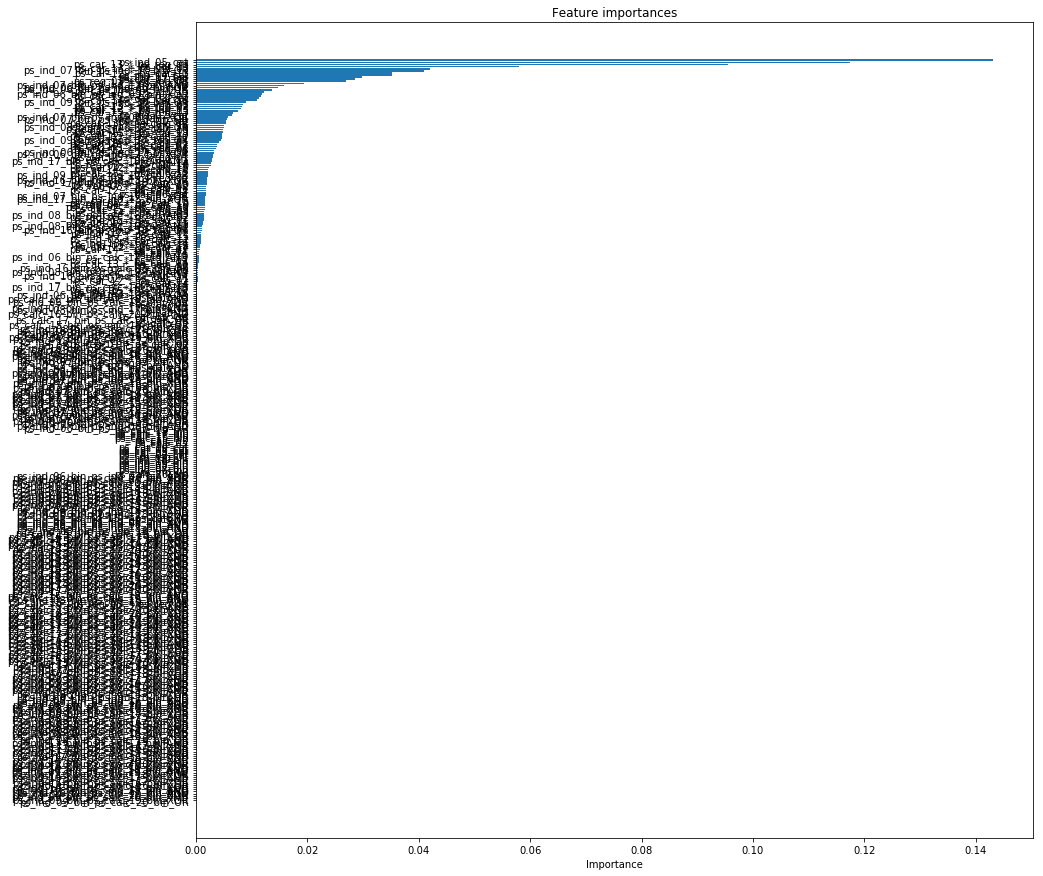

In [44]:
#''' 
plt.figure(figsize=(15, 15))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature importances')
plt.draw()
plt.show()
#''' 

In [45]:
#--- Predicting Gradient boost result for test data ---
y_GBR = GBR.predict(X_test)

In [46]:
#''' 
final = pd.DataFrame()
final['id'] = X_id_test
final['target'] = y_GBR
final.to_csv('Gradient_Boost_1.csv', index=False)
print('DONE!!')
#'''

DONE!!


## XGBoost

In [47]:
import xgboost as xgb

In [48]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

In [49]:
from sklearn.model_selection import StratifiedKFold

kfold = 5
skf = StratifiedKFold(n_splits=kfold, random_state=42)

In [50]:
params = {
    'min_child_weight': 10.0,
    'objective': 'binary:logistic',
    'max_depth': 7,
    'max_delta_step': 1.8,
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'eta': 0.025,
    'gamma': 0.65,
    'num_boost_round' : 700
    }

In [51]:
'''
for i, (train_index, test_index) in enumerate(skf.split(X_train, Y_train)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = X_train[train_index], X_train[test_index]
    y_train, y_valid = Y_train[train_index], Y_train[test_index]
    # Convert our data into XGBoost format
    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    d_test = xgb.DMatrix(X_test.values)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    # Train the model! We pass in a max of 1,600 rounds (with early stopping after 70)
    # and the custom metric (maximize=True tells xgb that higher metric is better)
    mdl = xgb.train(params, d_train, 1600, watchlist, early_stopping_rounds=70, feval=gini_xgb, maximize=True, verbose_eval=100)

    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    # Predict on our test data
    p_test = mdl.predict(d_test)
    sub['target'] += p_test/kfold
'''    

"\nfor i, (train_index, test_index) in enumerate(skf.split(X_train, Y_train)):\n    print('[Fold %d/%d]' % (i + 1, kfold))\n    X_train, X_valid = X_train[train_index], X_train[test_index]\n    y_train, y_valid = Y_train[train_index], Y_train[test_index]\n    # Convert our data into XGBoost format\n    d_train = xgb.DMatrix(X_train, y_train)\n    d_valid = xgb.DMatrix(X_valid, y_valid)\n    d_test = xgb.DMatrix(X_test.values)\n    watchlist = [(d_train, 'train'), (d_valid, 'valid')]\n\n    # Train the model! We pass in a max of 1,600 rounds (with early stopping after 70)\n    # and the custom metric (maximize=True tells xgb that higher metric is better)\n    mdl = xgb.train(params, d_train, 1600, watchlist, early_stopping_rounds=70, feval=gini_xgb, maximize=True, verbose_eval=100)\n\n    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))\n    # Predict on our test data\n    p_test = mdl.predict(d_test)\n    sub['target'] += p_test/kfold\n"

## Random Forest

In [52]:
''' 
from sklearn.ensemble import RandomForestClassifier  

RF = RandomForestClassifier(n_estimators=100, max_depth=8, criterion='entropy', min_samples_split=10, max_features=120, n_jobs=-1, random_state=123, verbose=1, class_weight = "balanced")
RF.fit(X_train, Y_train)

print(RF)

#--- List of important features ---

features_list = X_train.columns.values
feature_importance = RF.feature_importances_
sorted_idx = np.argsort(feature_importance)

print(sorted_idx)

plt.figure(figsize=(15, 15))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature importances')
plt.draw()
plt.show()

 
Y_pred = RF.predict(X_test)

final = pd.DataFrame()
final['id'] = X_id_test
final['target'] = Y_pred
final.to_csv('RF.csv', index=False)
print('DONE!!')

'''

' \nfrom sklearn.ensemble import RandomForestClassifier  \n\nRF = RandomForestClassifier(n_estimators=100, max_depth=8, criterion=\'entropy\', min_samples_split=10, max_features=120, n_jobs=-1, random_state=123, verbose=1, class_weight = "balanced")\nRF.fit(X_train, Y_train)\n\nprint(RF)\n\n#--- List of important features ---\n\nfeatures_list = X_train.columns.values\nfeature_importance = RF.feature_importances_\nsorted_idx = np.argsort(feature_importance)\n\nprint(sorted_idx)\n\nplt.figure(figsize=(15, 15))\nplt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align=\'center\')\nplt.yticks(range(len(sorted_idx)), features_list[sorted_idx])\nplt.xlabel(\'Importance\')\nplt.title(\'Feature importances\')\nplt.draw()\nplt.show()\n\n \nY_pred = RF.predict(X_test)\n\nfinal = pd.DataFrame()\nfinal[\'id\'] = X_id_test\nfinal[\'target\'] = Y_pred\nfinal.to_csv(\'RF.csv\', index=False)\nprint(\'DONE!!\')\n\n'

In [53]:
#-- Adaboost ---
'''
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

Ada_R = AdaBoostRegressor(DecisionTreeRegressor(max_depth=7), n_estimators = 400, random_state = 99)

Ada_R.fit(X_train, Y_train)

print (Ada_R)

features_list = X_train.columns.values
feature_importance = Ada_R.feature_importances_
sorted_idx = np.argsort(feature_importance)

print(sorted_idx)

plt.figure(figsize=(15, 15))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature importances')
plt.draw()
plt.show()

#--- Predicting Ada boost result for test data ---
y_Ada = Ada_R.predict(X_test)


final = pd.DataFrame()
final['id'] = X_id_test
final['target'] = y_Ada
final.to_csv('Ada_Boost_1.csv', index=False)
print('DONE!!')
''' 

"\nfrom sklearn.tree import DecisionTreeRegressor\nfrom sklearn.ensemble import AdaBoostRegressor\n\nAda_R = AdaBoostRegressor(DecisionTreeRegressor(max_depth=7), n_estimators = 400, random_state = 99)\n\nAda_R.fit(X_train, Y_train)\n\nprint (Ada_R)\n\nfeatures_list = X_train.columns.values\nfeature_importance = Ada_R.feature_importances_\nsorted_idx = np.argsort(feature_importance)\n\nprint(sorted_idx)\n\nplt.figure(figsize=(15, 15))\nplt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')\nplt.yticks(range(len(sorted_idx)), features_list[sorted_idx])\nplt.xlabel('Importance')\nplt.title('Feature importances')\nplt.draw()\nplt.show()\n\n#--- Predicting Ada boost result for test data ---\ny_Ada = Ada_R.predict(X_test)\n\n\nfinal = pd.DataFrame()\nfinal['id'] = X_id_test\nfinal['target'] = y_Ada\nfinal.to_csv('Ada_Boost_1.csv', index=False)\nprint('DONE!!')\n"

In [54]:
'''  

from sklearn.cross_validation import train_test_split
import xgboost as xgb

X_train = df_train.drop(['id'],axis = 1)
X_id_train = df_train['id'].values
Y_train = target.values

X_test = df_test.drop(['id'], axis=1)
X_id_test = df_test['id'].values

x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=4242)
print('Train samples: {} Validation samples: {}'.format(len(x_train), len(x_valid)))

d_train = xgb.DMatrix(x_train, y_train)
d_valid = xgb.DMatrix(x_valid, y_valid)
d_test = xgb.DMatrix(X_test)

params = {}
params['min_child_weight'] = 10.0
params['objective'] = 'binary:logistic'
params['eta'] = 0.02
params['silent'] = True
params['max_depth'] = 9
params['subsample'] = 0.9
params['colsample_bytree'] = 0.9

# Define the gini metric - from https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703#5897
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

# Create an XGBoost-compatible metric from Gini

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return [('gini', gini_score)]

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

model = xgb.train(params, d_train, 100, watchlist, early_stopping_rounds=100, feval=gini_xgb, maximize=True, verbose_eval=10)

xgb.plot_importance(model)
fig, ax = plt.subplots(figsize=(12,18))
plt.show()

p_test = model.predict(d_test)

#--- Submission file ---

sub = pd.DataFrame()
sub['id'] = X_id_test
sub['target'] = p_test
sub.to_csv('xgb2.csv', index=False)


importance = model.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])

plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 25))
plt.gcf().savefig('features_importance.png')
''' 

"  \n\nfrom sklearn.cross_validation import train_test_split\nimport xgboost as xgb\n\nX_train = df_train.drop(['id'],axis = 1)\nX_id_train = df_train['id'].values\nY_train = target.values\n\nX_test = df_test.drop(['id'], axis=1)\nX_id_test = df_test['id'].values\n\nx_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=4242)\nprint('Train samples: {} Validation samples: {}'.format(len(x_train), len(x_valid)))\n\nd_train = xgb.DMatrix(x_train, y_train)\nd_valid = xgb.DMatrix(x_valid, y_valid)\nd_test = xgb.DMatrix(X_test)\n\nparams = {}\nparams['min_child_weight'] = 10.0\nparams['objective'] = 'binary:logistic'\nparams['eta'] = 0.02\nparams['silent'] = True\nparams['max_depth'] = 9\nparams['subsample'] = 0.9\nparams['colsample_bytree'] = 0.9\n\n# Define the gini metric - from https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703#5897\ndef gini(actual, pred, cmpcol = 0, sortcol = 1):\n    assert( len(actual) == len(pred) )\n    all

### Can you think of more features? Let me know in the comments!

# STAY TUNED FOR MORE UPDATES !!!